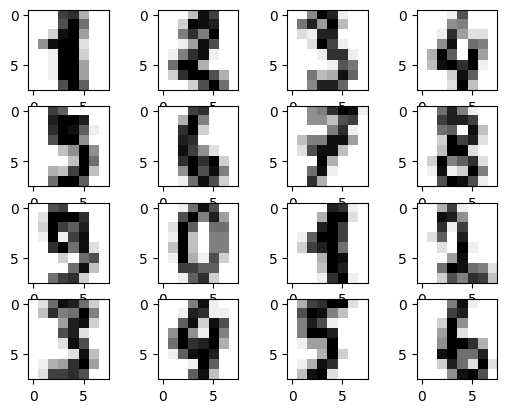

In [1]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import sklearn
import matplotlib.pyplot as plt
import numpy as np

digits = load_digits()

for i in range(1,17):
    plt.subplot(4,4,i)
    plt.imshow(digits.images[i,:,:], cmap=plt.get_cmap('gray_r'))


Generamos un MLP sencillito para reconocimiento de numeros en MNIST

In [2]:
import torch.nn as nn
import torch

class MLP(nn.Module):
    def __init__(self, input_features, n_embeddings, n_output):
        super(MLP, self).__init__()
        self.embedding_layer = nn.Linear(input_features,n_embeddings)
        self.middle_layer = nn.Linear(n_embeddings,n_embeddings)
        self.output_layer = nn.Linear(n_embeddings,n_output)

        self.relu= nn.ReLU()

    def embed(self,x):
        x = self.embedding_layer(x)
        x = self.relu(x)
        return x

    def forward(self,x):
        x = self.embed(x)
        x = self.middle_layer(x)
        x = self.relu(x)
        x = self.output_layer(x)
        x = self.relu(x)
        return x

In [3]:
!pip install pmlb

Epoch 100, loss = 20.3791
Epoch 200, loss = 21.292
Epoch 300, loss = 15.685
Epoch 400, loss = 14.5459
Epoch 500, loss = 18.2957
Epoch 600, loss = 16.8064
Epoch 700, loss = 10.8142
Epoch 800, loss = 10.9744
Epoch 900, loss = 10.9062
Epoch 1000, loss = 9.50735
Epoch 1100, loss = 8.48958
Epoch 1200, loss = 7.53453
Epoch 1300, loss = 6.25087
Epoch 1400, loss = 4.24255
Epoch 1500, loss = 4.21541
Epoch 1600, loss = 6.26692
Epoch 1700, loss = 2.19215
Epoch 1800, loss = 2.53404
Epoch 1900, loss = 2.03059
Epoch 2000, loss = 2.02459
Epoch 2100, loss = 1.92196
Epoch 2200, loss = 1.04515
Epoch 2300, loss = 1.33293
Epoch 2400, loss = 0.561898
Epoch 2500, loss = 3.22041
Epoch 2600, loss = 1.73693
Epoch 2700, loss = 0.278253
Epoch 2800, loss = 0.533093
Epoch 2900, loss = 0.647281
Epoch 3000, loss = 2.52137
Epoch 3100, loss = 0.28614
Epoch 3200, loss = 0.470201
Epoch 3300, loss = 0.154659
Epoch 3400, loss = 0.906566
Epoch 3500, loss = 0.574841
Epoch 3600, loss = 0.518421
Epoch 3700, loss = 0.142131
Ep

Text(0.5, 1.0, 'Función de pérdida durante el entrenamiento')

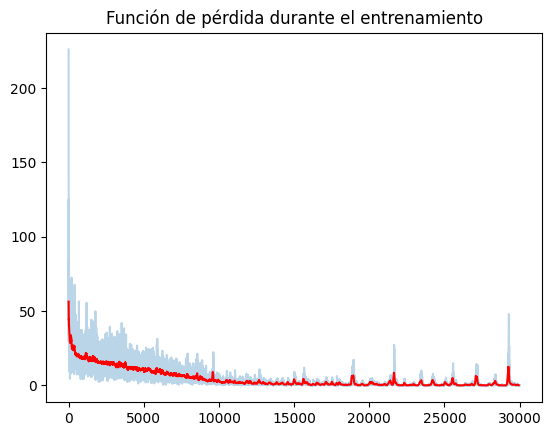

In [5]:
from pmlb import fetch_data

# Importamos el dataset
body_fat = fetch_data('560_bodyfat')
body_fat.describe()

# Extraigo los datos (features) y los porcentajes (etiquetas a predecir)
data = body_fat.loc[:, body_fat.columns != 'target'].to_numpy()
percentages = body_fat.loc[:, body_fat.columns == 'target'].to_numpy()
# Convert data and percentages to float32 BEFORE creating tensors
data = data.astype(np.float32)
percentages = percentages.astype(np.float32) # This line is the fix

from sklearn.model_selection import train_test_split

# Particiono los datos en entrenamiento y prueba usando el método de scikitlearn
X_train, X_test, y_train, y_test = train_test_split(data , percentages , test_size=0.33, random_state=42)

from torch.utils.data import TensorDataset, DataLoader

# Tamaño del batch de entrenamiento
batch_size = 32

# Tasa de aprendizaje inicial para el gradiente descendente
learning_rate = 1e-3

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

mlp = MLP( 14 , 200, 1 ).to(device)


# Construimos el optimizador, y le indicamos que los parámetros a optimizar
# son los del modelo definido: net.parameters()

optimizer = torch.optim.Adam(mlp.parameters(), lr=learning_rate)

# Definimos también la función de pérdida a utilizar
criterion = nn.MSELoss(reduction='mean')


# Creamos el objeto dataset que empaqueta los array de numpy para que puedan
# ser leidos por PyTorch
dataset = TensorDataset(torch.from_numpy(X_train).clone(), torch.from_numpy(y_train).clone())

# Creamos un loader iterable indicandole que debe leer los datos a partir de
# del dataset creado en el paso anterior. Este objeto puede ser iterado
# y nos devuelve de a un batch (x, y).
loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

# Número de épocas
num_epochs = 5000

# Lista en la que iremos guardando el valor de la función de pérdida en cada
# etapa de entrenamiento
loss_list = []

# Bucle de entrenamiento
for i in range(num_epochs):

    total_loss = 0.0
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        # Seteo en cero los gradientes de los parámetros a optimizar
        optimizer.zero_grad()

        # Realizo la pasada forward por la red
        output = mlp(x)
        loss = criterion(output, y)

        # Realizo la pasada backward por la red
        loss.backward()

        # Actualizo los pesos de la red con el optimizador
        optimizer.step()

        # Me guardo el valor actual de la función de pérdida para luego graficarlo
        loss_list.append(loss.data.item())

        # Acumulo la loss del minibatch
        total_loss += loss.item() * y.size(0)

    # Normalizo la loss total
    total_loss/= len(loader.dataset)

    # Muestro el valor de la función de pérdida cada 100 iteraciones
    if i > 0 and i % 100 == 0:
        print('Epoch %d, loss = %g' % (i, total_loss))

# Muestro la lista que contiene los valores de la función de pérdida
# y una versión suavizada (rojo) para observar la tendencia
plt.figure()
loss_np_array = np.array(loss_list)
plt.plot(loss_np_array, alpha = 0.3)
N = 60
running_avg_loss = np.convolve(loss_np_array, np.ones((N,))/N, mode='valid')
plt.plot(running_avg_loss, color='red')
plt.title("Función de pérdida durante el entrenamiento")

In [6]:
import autoencoder as auto

In [7]:
from scipy.spatial.distance import cdist

def geometric_median(points, eps=1e-6, max_iter=1000):
    """
    Calculate the geometric median of a set of points using Weiszfeld's algorithm.

    Parameters:
    points: numpy array of shape (n, d) where n is number of points and d is dimensions
    eps: convergence threshold
    max_iter: maximum number of iterations

    Returns:
    geometric_median: numpy array of shape (d,)
    n_iter: number of iterations performed
    """
    # Initial guess: centroid
    y = np.mean(points, axis=0)

    for iter_count in range(max_iter):
        # Calculate distances from current estimate to all points
        distances = cdist(points, y.reshape(1, -1)).ravel()

        # Handle zero distances to avoid division by zero
        distances[distances < eps] = eps

        # Compute weights
        weights = 1 / distances

        # Calculate new estimate
        y_new = np.average(points, axis=0, weights=weights)

        # Check convergence
        if np.linalg.norm(y - y_new) < eps:
            return y_new, iter_count + 1

        y = y_new

    return y, max_iter

In [ ]:
geo_median, _ = geometric_median(data)

In [8]:
autoencoder = auto.Autoencoder(
                  dim_activaciones = 200,
                  dim_rala = 400,
                  dataset_geometric_median = np.zeros(200)
              ).to(device)

Epoch 100, loss = 3.36624
Epoch 200, loss = 2.77142
Epoch 300, loss = 2.86403
Epoch 400, loss = 2.28779
Epoch 500, loss = 2.43097
Epoch 600, loss = 2.06204
Epoch 700, loss = 2.22451
Epoch 800, loss = 2.28613
Epoch 900, loss = 2.00847
Epoch 1000, loss = 2.05385
Epoch 1100, loss = 2.18214
Epoch 1200, loss = 2.01653
Epoch 1300, loss = 2.00238
Epoch 1400, loss = 1.90484
Epoch 1500, loss = 1.81945
Epoch 1600, loss = 1.67528
Epoch 1700, loss = 1.53573
Epoch 1800, loss = 1.64163
Epoch 1900, loss = 1.70428
Epoch 2000, loss = 1.4429
Epoch 2100, loss = 1.39496
Epoch 2200, loss = 1.4076
Epoch 2300, loss = 1.30996
Epoch 2400, loss = 1.17592
Epoch 2500, loss = 1.14959
Epoch 2600, loss = 1.11052
Epoch 2700, loss = 1.04903
Epoch 2800, loss = 1.0109
Epoch 2900, loss = 0.983531
Epoch 3000, loss = 0.960267
Epoch 3100, loss = 0.906473
Epoch 3200, loss = 0.849881
Epoch 3300, loss = 0.824342
Epoch 3400, loss = 0.797204
Epoch 3500, loss = 0.786922
Epoch 3600, loss = 0.757776
Epoch 3700, loss = 0.733063
Epoc

Text(0.5, 1.0, 'Función de pérdida durante el entrenamiento AUTOENCODER')

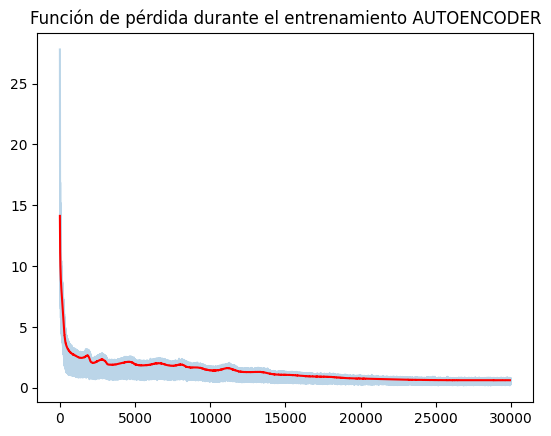

In [9]:
loss_list = []

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)

criterion = auto.lossAutoencoder()

# Bucle de entrenamiento
for i in range(num_epochs):

    total_loss = 0.0
    for x, y in loader:
        x = x.to(device)

        #Agarro las activaciones del mlp, sin pasar por gradiente
        with torch.no_grad():
            x_embedding = mlp.embed(x)

        # Seteo en cero los gradientes de los parámetros a optimizar
        optimizer.zero_grad()

        # Realizo la pasada forward por la red
        encoded, decoded = autoencoder(x_embedding)
        loss = criterion(x_embedding, encoded, decoded)

        # Realizo la pasada backward por la red
        loss.backward()

        # Actualizo los pesos de la red con el optimizador
        optimizer.step()

        # Normalizo los pesos del decoder
        autoencoder.normalize_decoder_weights()

        # Me guardo el valor actual de la función de pérdida para luego graficarlo
        loss_list.append(loss.data.item())

        # Acumulo la loss del minibatch
        total_loss += loss.item() * x.size(0)

    # Normalizo la loss total
    total_loss/= len(loader.dataset)

    # Muestro el valor de la función de pérdida cada 100 iteraciones
    if i > 0 and i % 100 == 0:
        print('Epoch %d, loss = %g' % (i, total_loss))

# Muestro la lista que contiene los valores de la función de pérdida
# y una versión suavizada (rojo) para observar la tendencia
plt.figure()
loss_np_array = np.array(loss_list)
plt.plot(loss_np_array, alpha = 0.3)
N = 60
running_avg_loss = np.convolve(loss_np_array, np.ones((N,))/N, mode='valid')
plt.plot(running_avg_loss, color='red')
plt.title("Función de pérdida durante el entrenamiento AUTOENCODER")